In [11]:
from posteriordb import PosteriorDatabase
import os
import json
import bridgestan as bs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stein_thinning.stein import ksd
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_centkgm

from stein_pi_thinning.target import PiTargetCentKGM
from stein_pi_thinning.mcmc import mala_adapt
from stein_pi_thinning.util import flat, nearestPD
from stein_pi_thinning.progress_bar import disable_progress_bar

import wasserstein


np.random.seed(1234)
# disable_progress_bar()

### Model Preparation

In [2]:
# Load DataBase Locally
pdb_path = os.path.join("../posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("mcycle_gp-accel_gp")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

In [3]:
# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s

gs_matrix = np.array([df.values[0,i] for i in range(df.shape[1])]).T

### P Target and Q Target

In [4]:
# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [5]:
# Construct log-Pi-pdf and its gradient
# Using Centralised KGM kernel
# linv is -Hessian Matrix at P mode

# Stein Centralised KGM kernel
dim = model.param_num()
x_unconstrain_map = model.param_unconstrain(np.mean(gs_chains, axis=1))
linv = -hess_log_p(x_unconstrain_map)
s = 3.0

stein_q_kgm = PiTargetCentKGM(log_p, grad_log_p, hess_log_p, linv, s, x_unconstrain_map)
log_q = stein_q_kgm.log_q
grad_log_q = stein_q_kgm.grad_log_q

In [6]:
# MALA With pre-conditioning
# Parameters
nits = 1_000_000 # the number of iterations

alpha = 10 * [1]
epoch = 9 * [1_000] + [nits]

_, _, x_p_epoch, _, _, nacc_p = mala_adapt(log_p, grad_log_p, x_unconstrain_map, 0.1, np.eye(dim), alpha, epoch)
print('acc_p =', np.mean(nacc_p[-1]))

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

acc_p = 0.753849


In [7]:
_, _, x_q_epoch, _, _, nacc_q = mala_adapt(log_q, grad_log_q, x_unconstrain_map, 0.1, np.eye(dim), alpha, epoch)
print('acc_q =', np.mean(nacc_q[-1]))

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

/home/congye/Code/PythonProjects/Stein-Pi-Thinning/stein_pi_thinning/target.py:265: RuntimeWarning: invalid value encountered in log
  return self.log_p(x) + 0.5 * np.log(self.stein_kernel(x))


acc_q = 0.81227


In [8]:
x_p_unconstrain = np.array(x_p_epoch[-1], dtype=np.float64)
grad_x_p_unconstrain = np.array([grad_log_p(i) for i in x_p_unconstrain])

x_q_unconstrain = np.array(x_q_epoch[-1], dtype=np.float64)
grad_x_q_unconstrain = np.array([grad_log_p(i) for i in x_q_unconstrain])

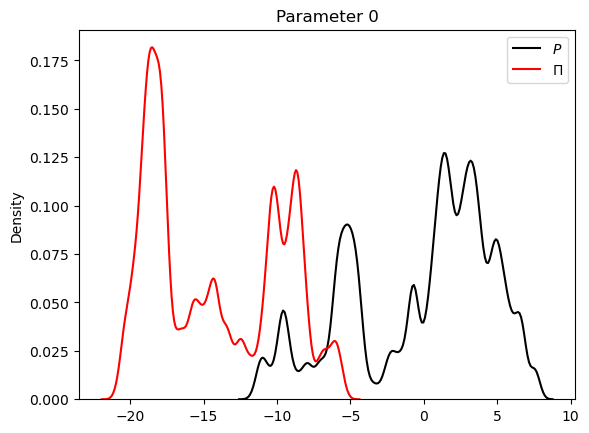

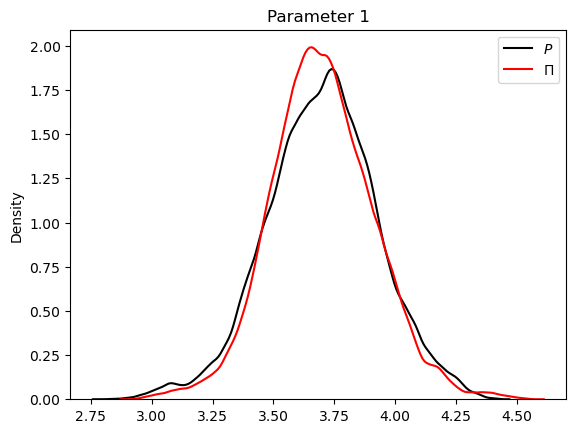

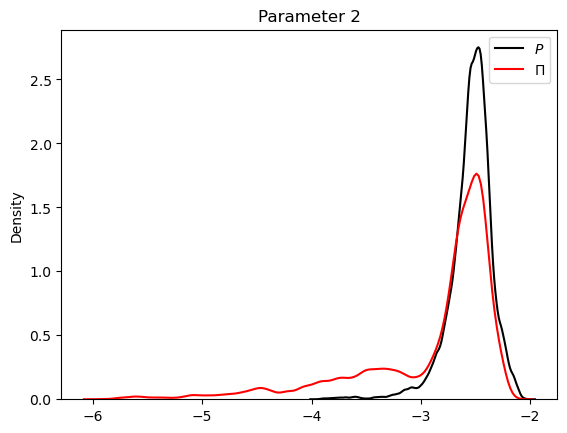

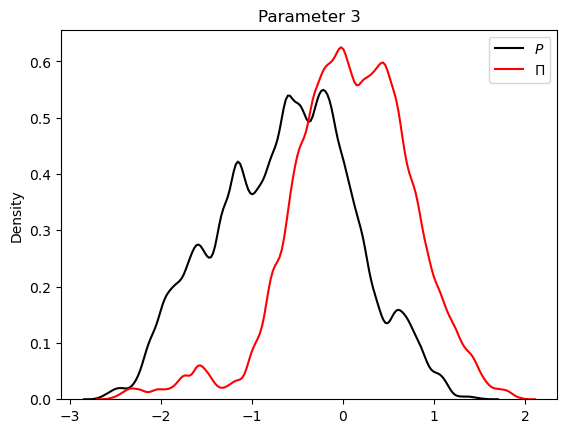

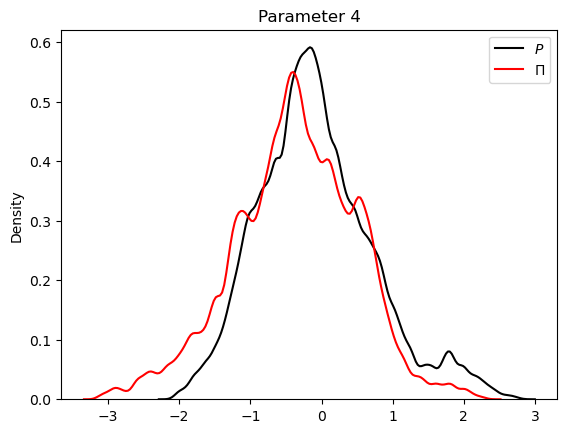

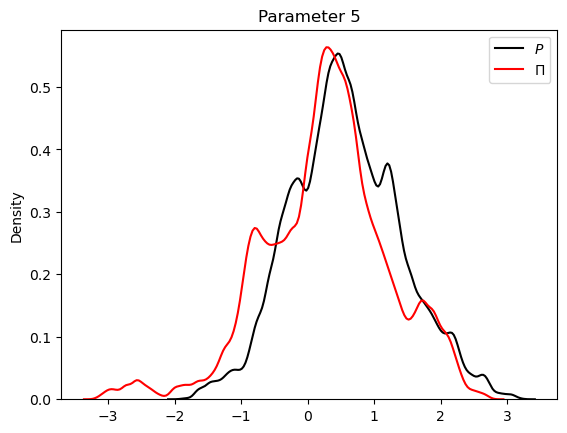

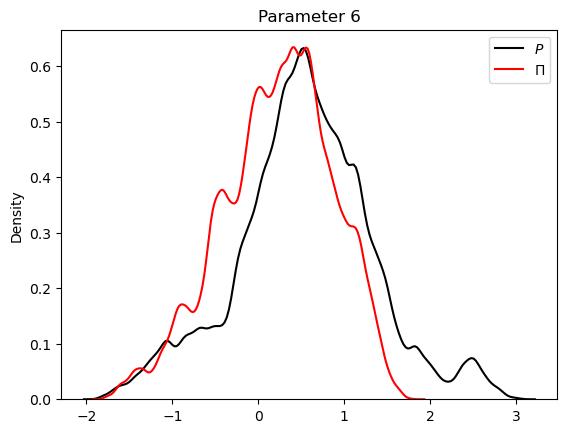

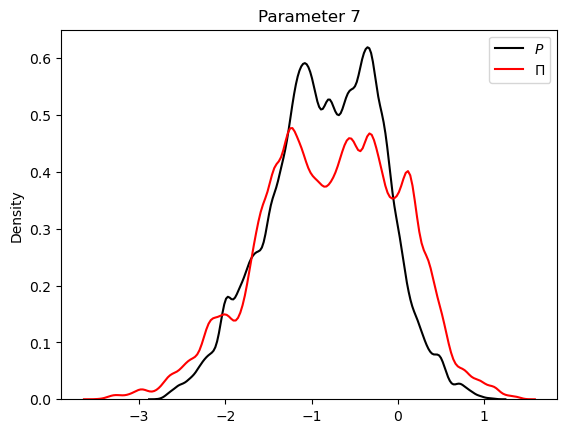

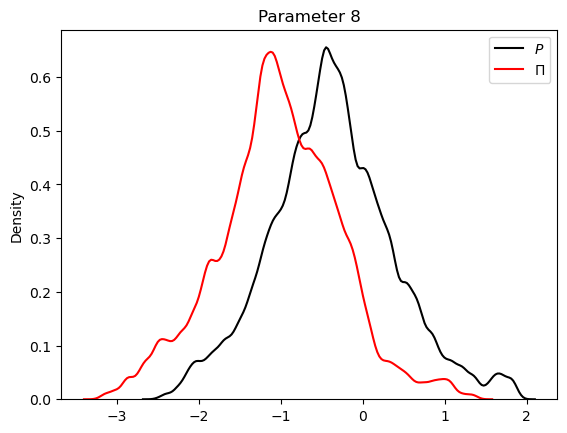

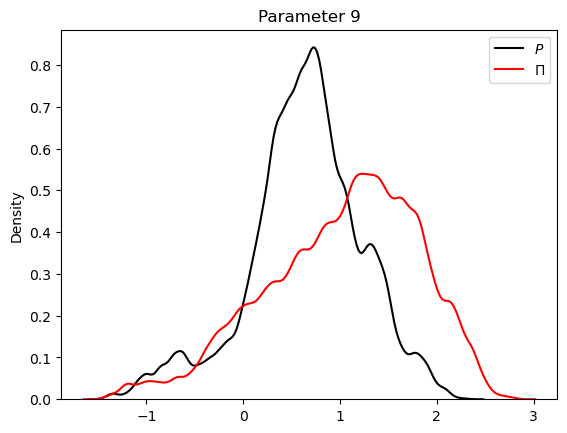

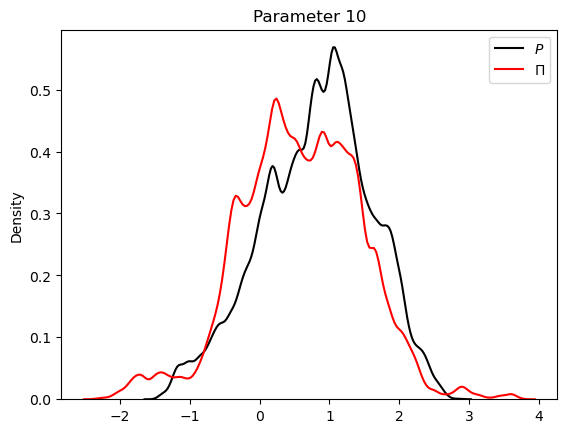

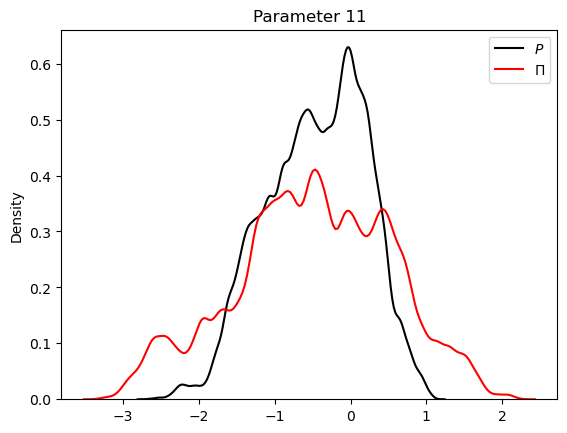

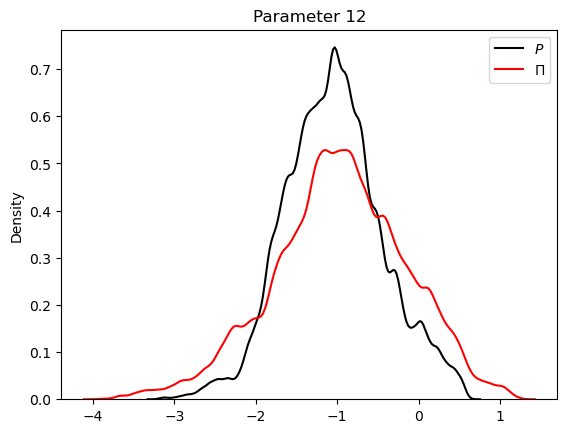

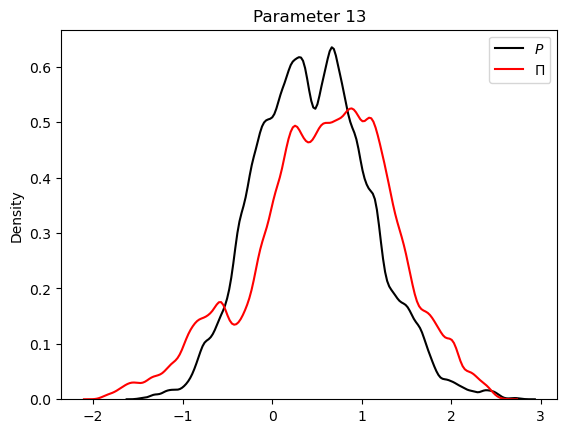

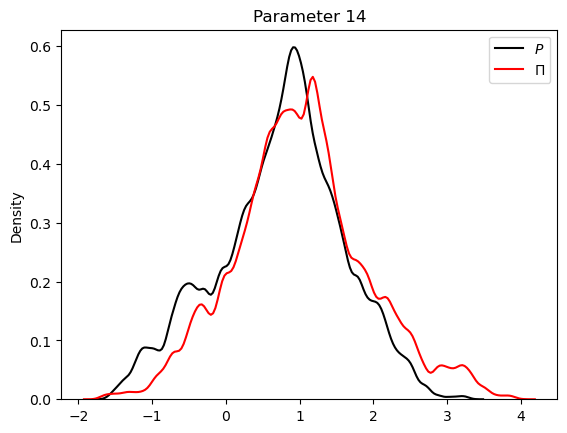

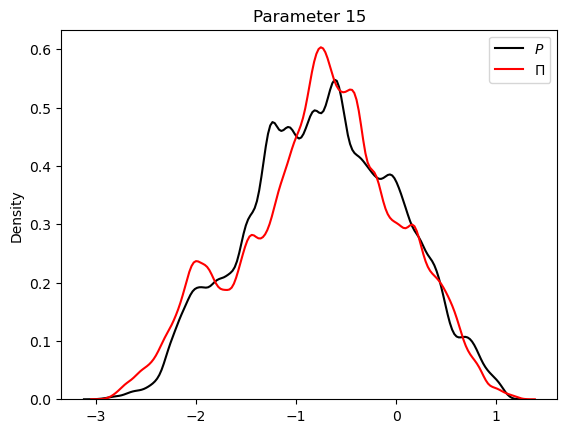

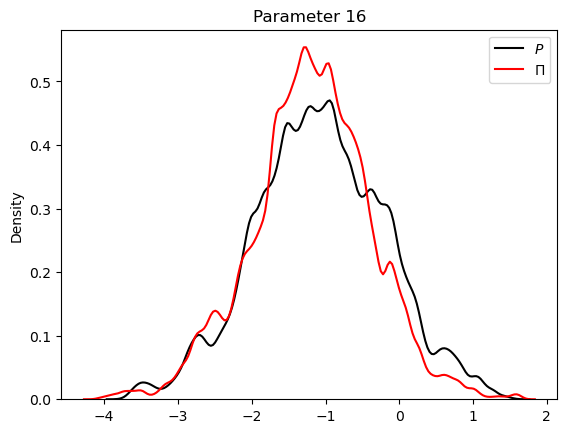

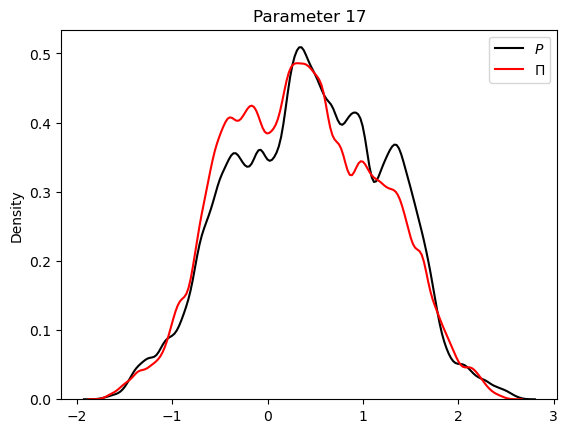

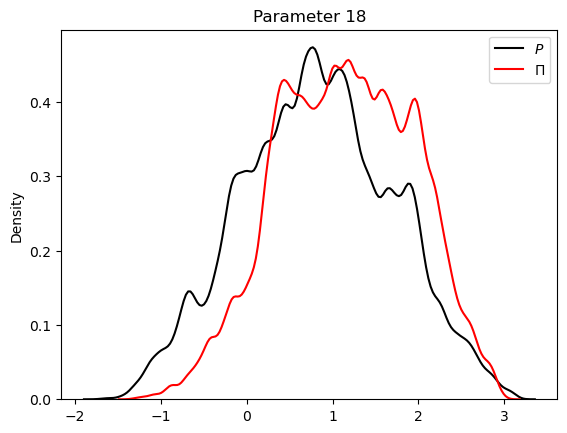

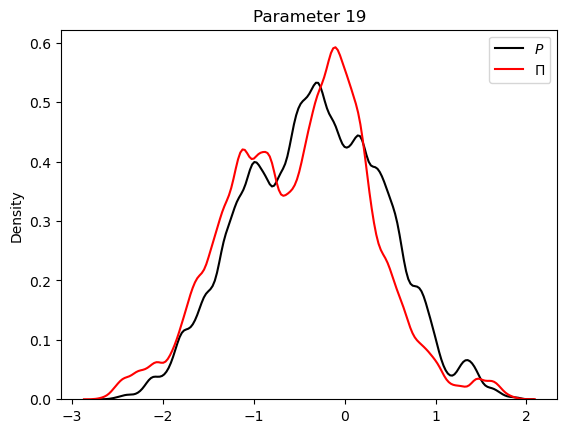

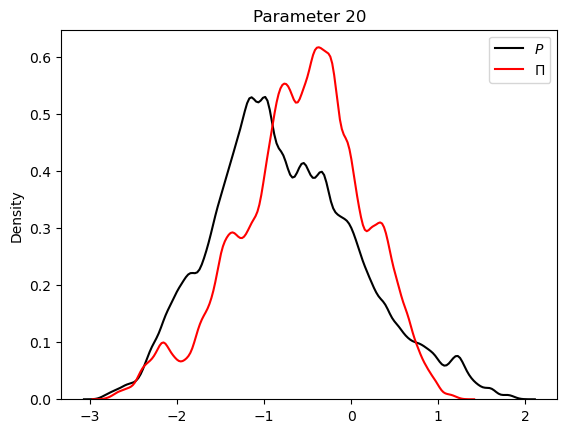

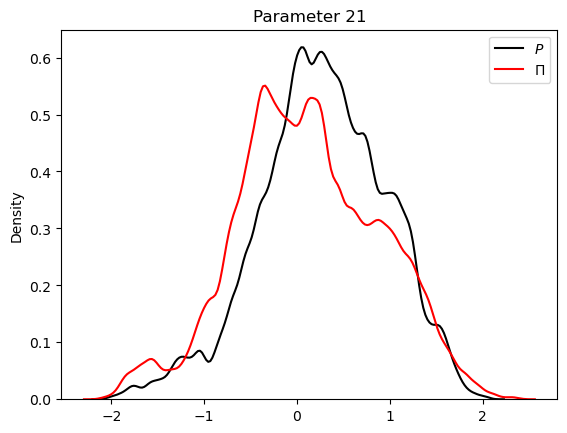

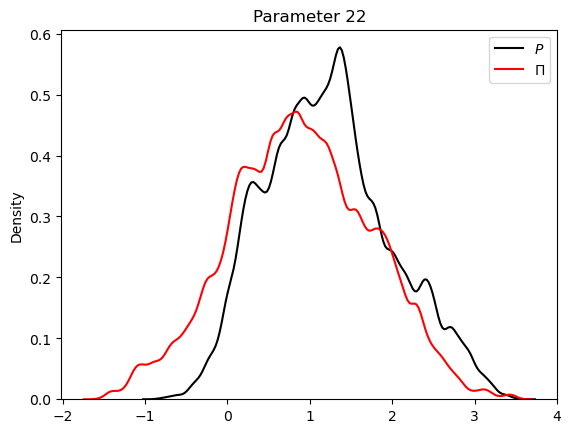

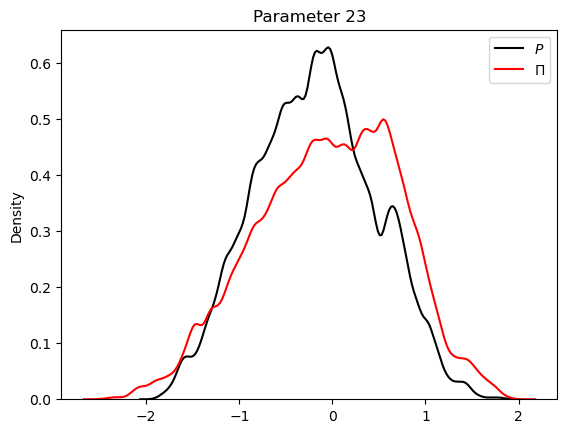

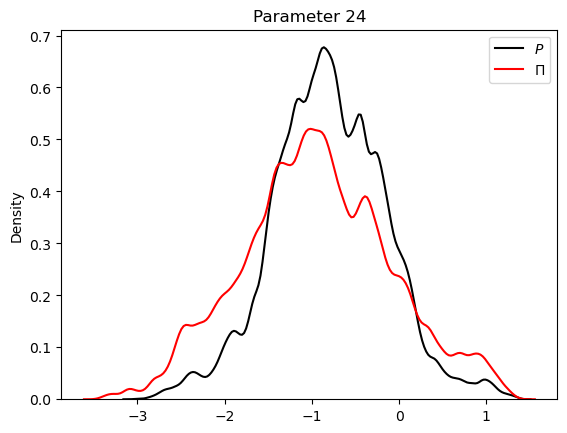

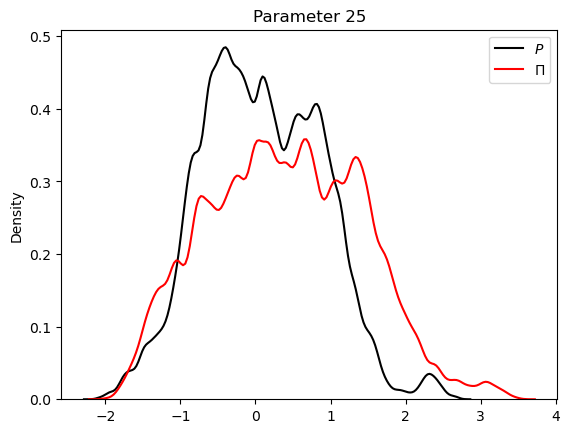

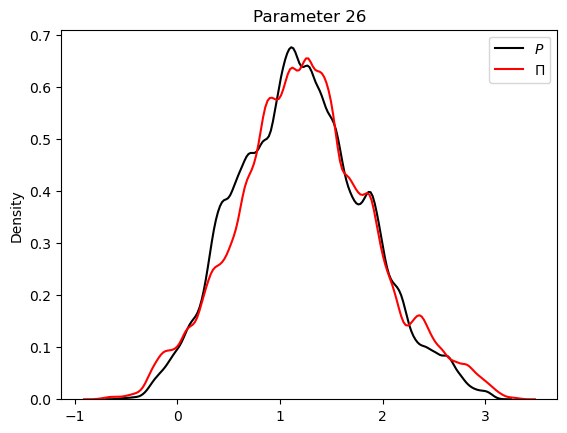

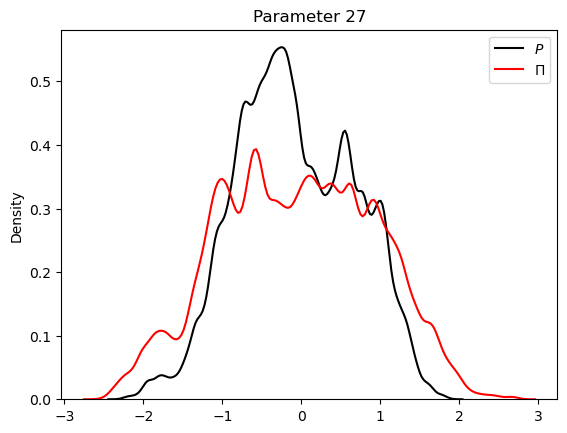

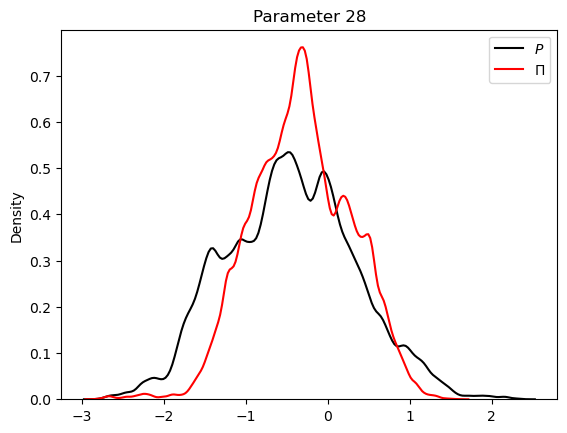

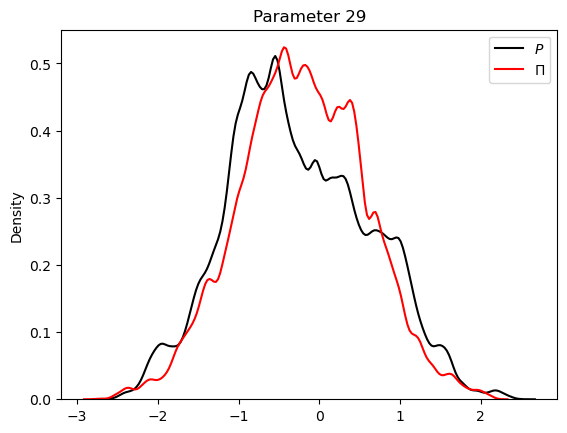

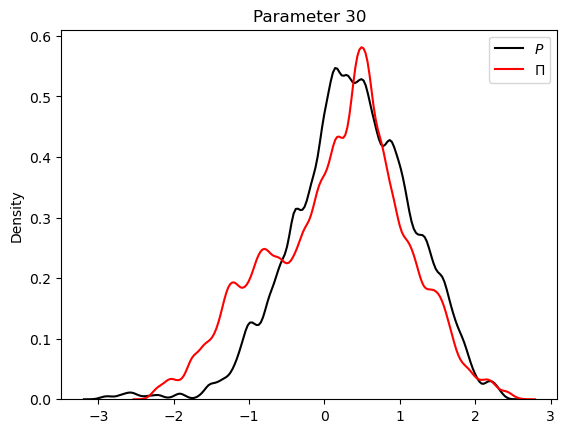

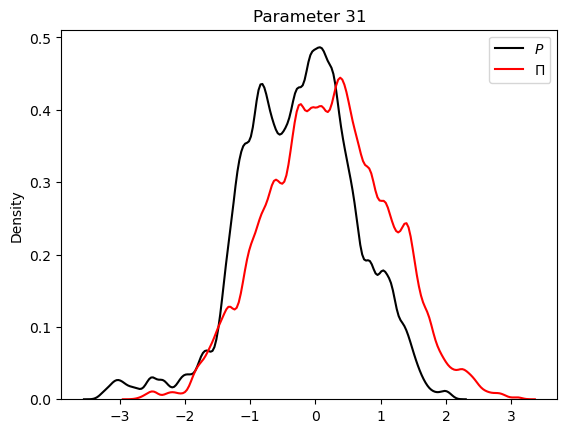

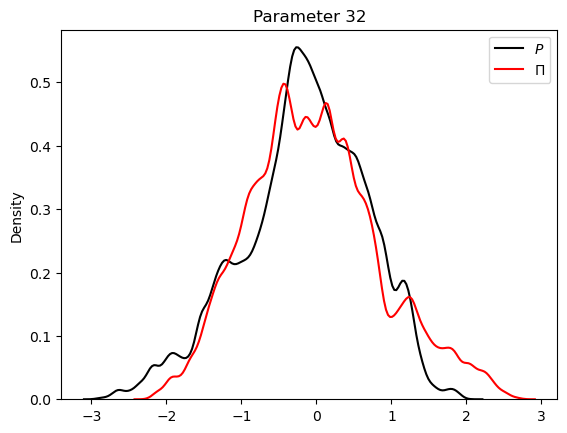

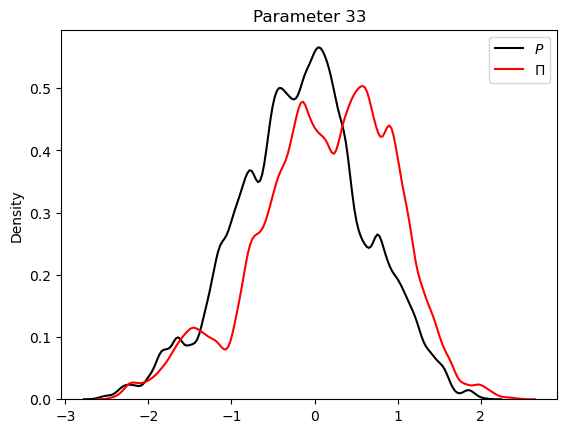

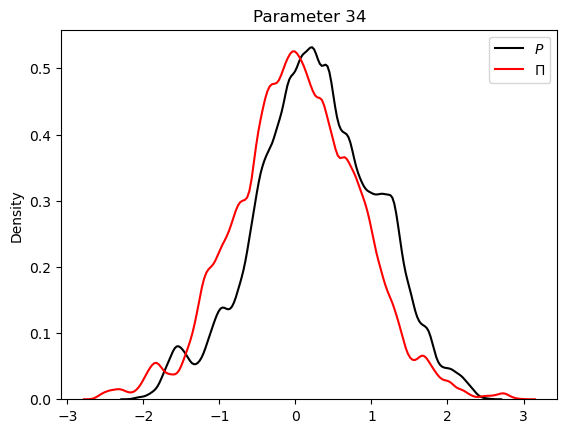

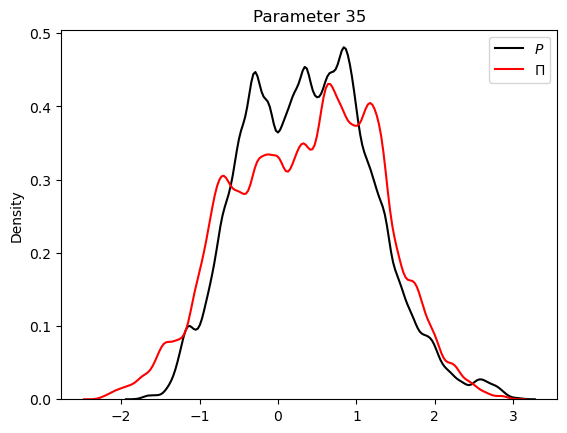

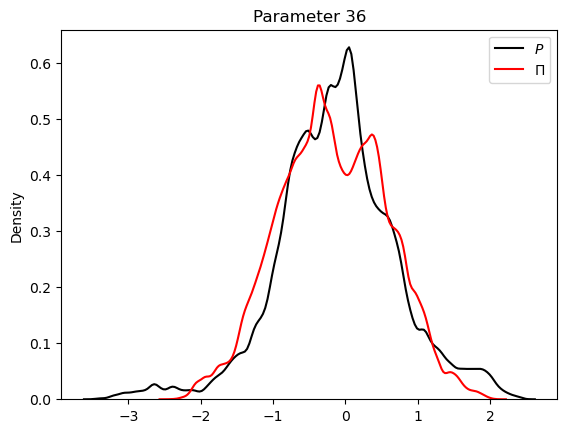

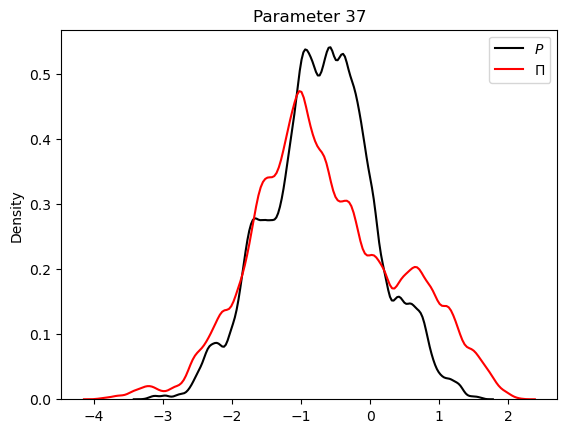

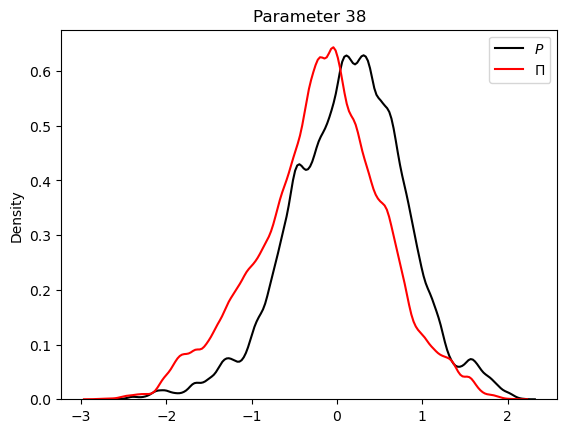

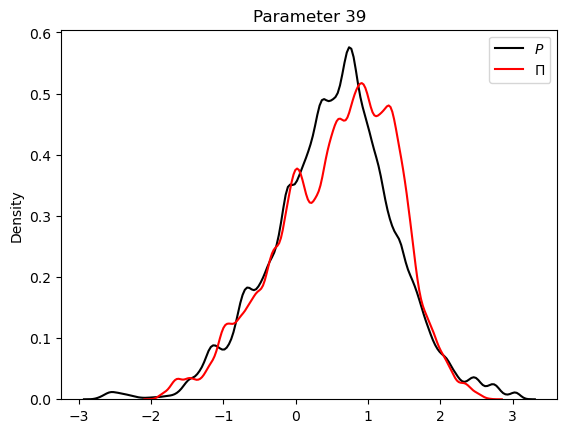

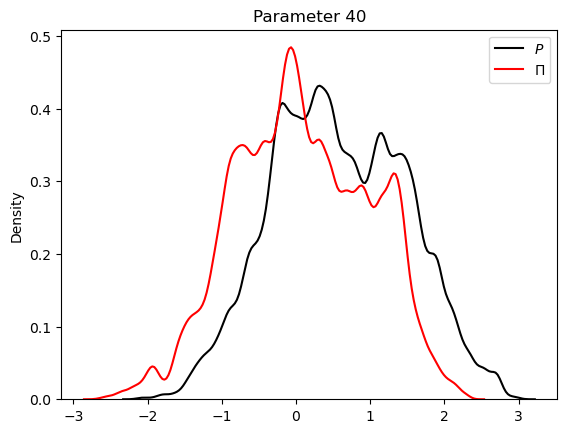

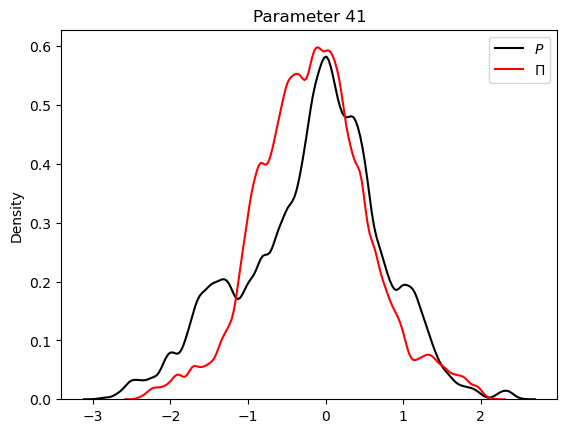

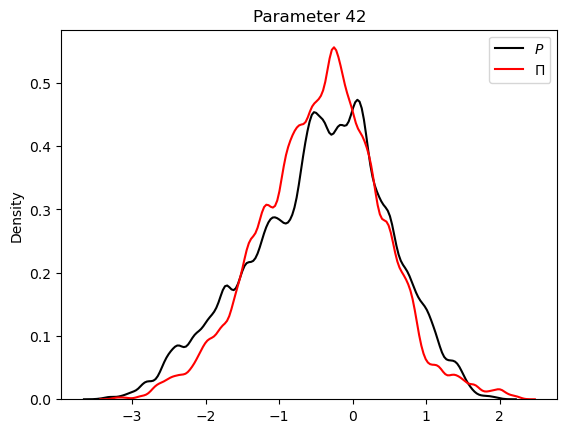

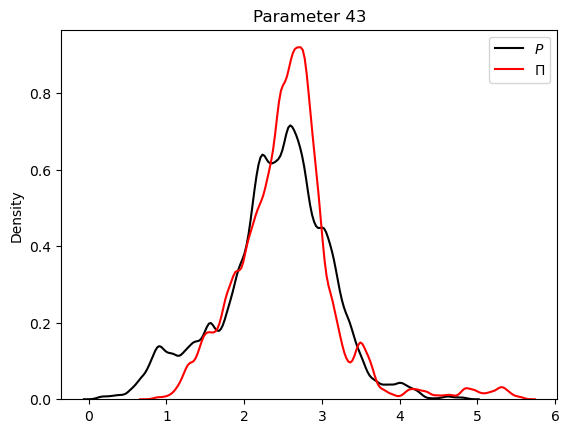

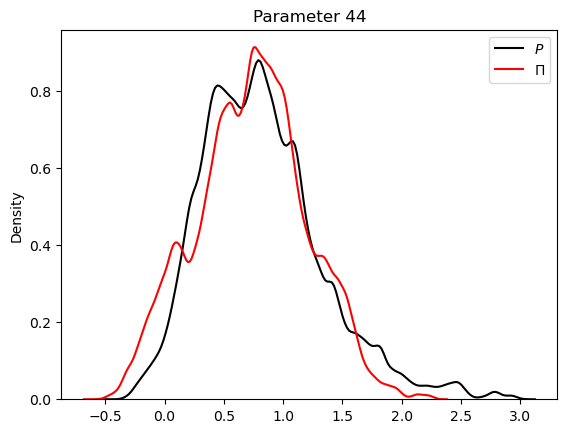

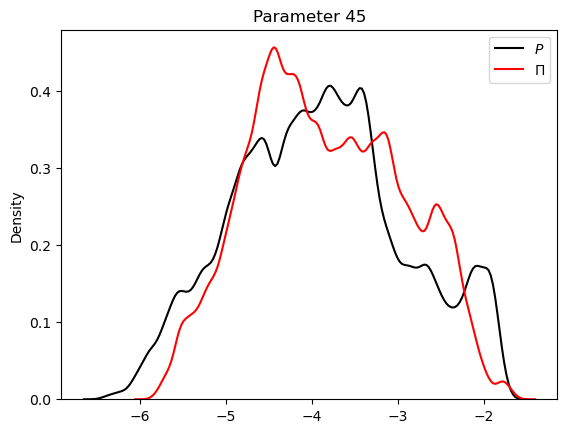

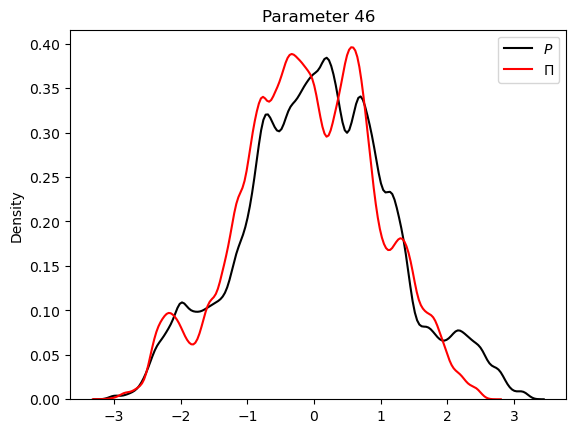

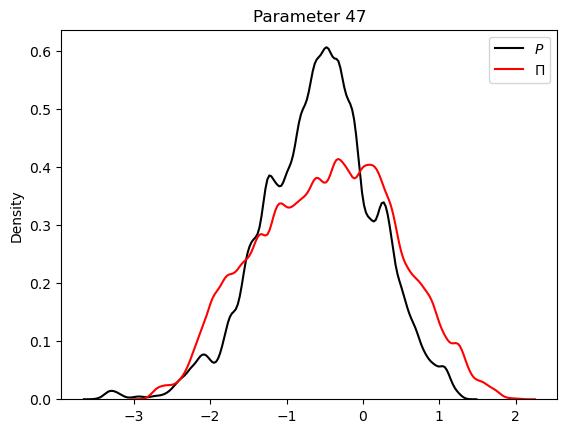

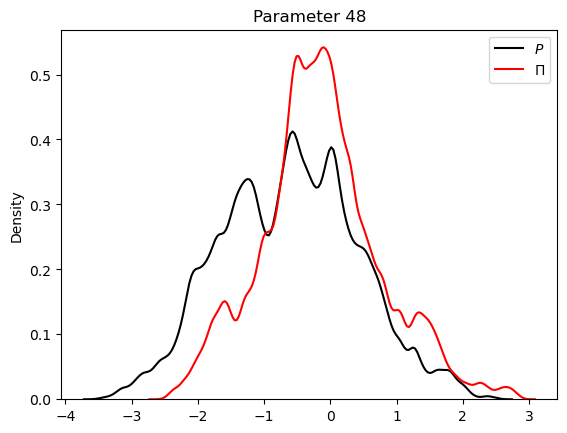

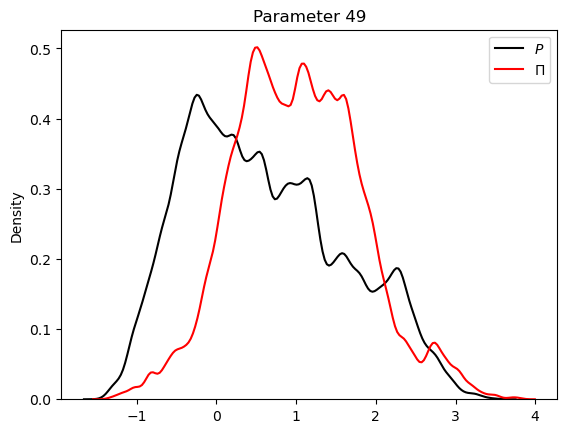

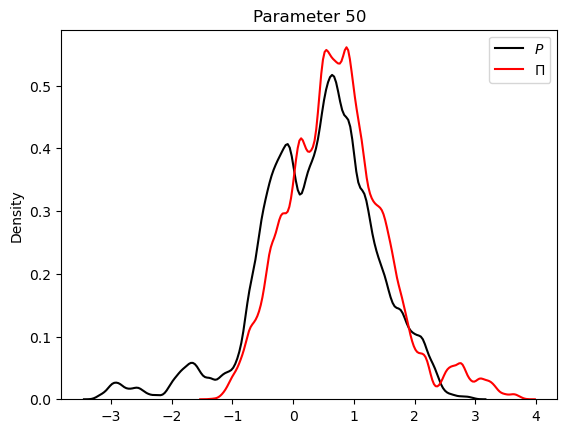

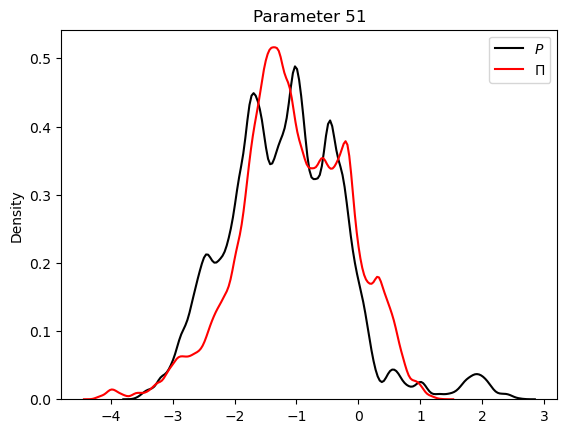

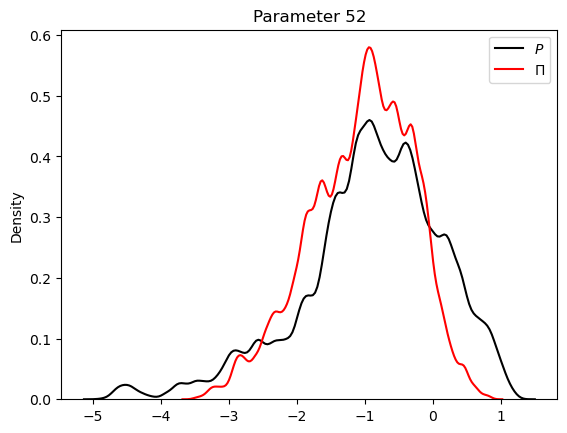

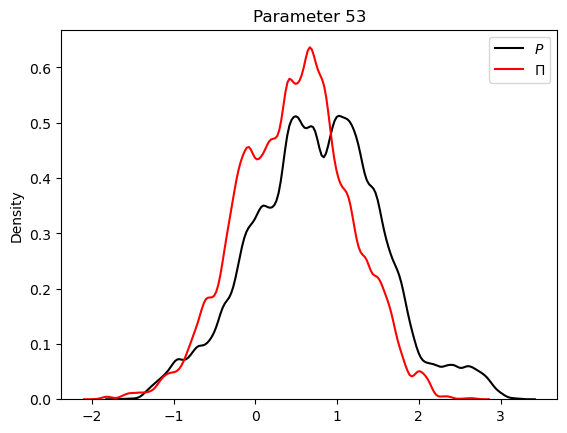

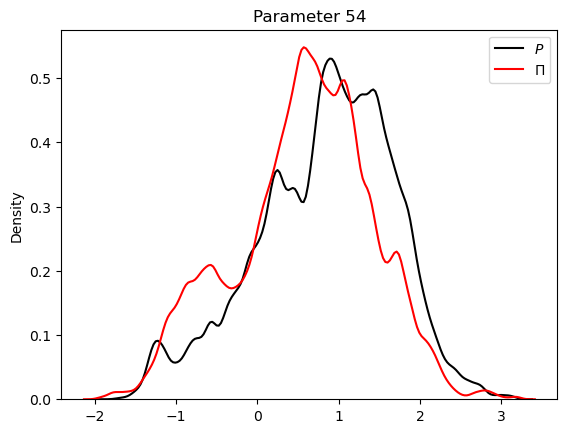

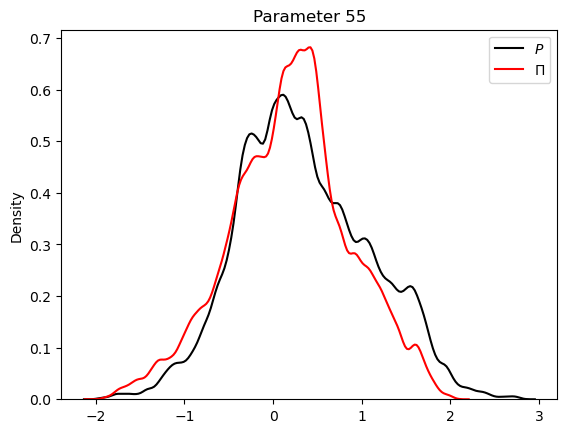

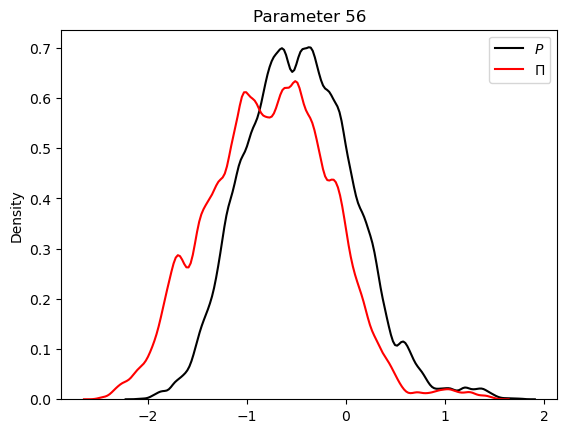

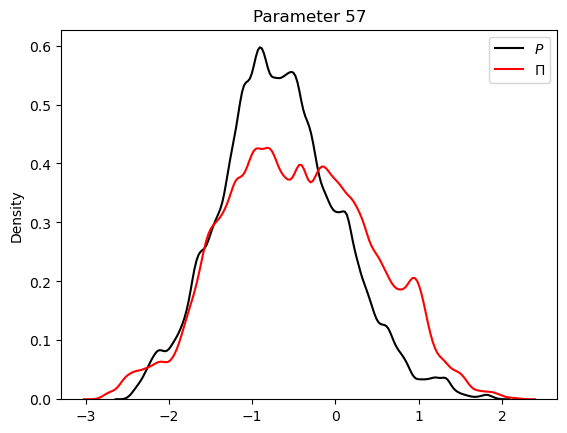

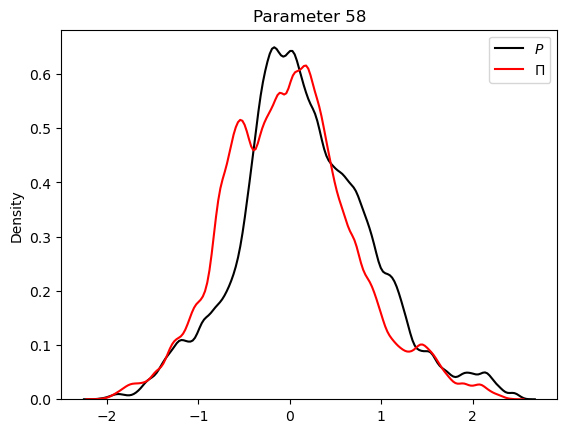

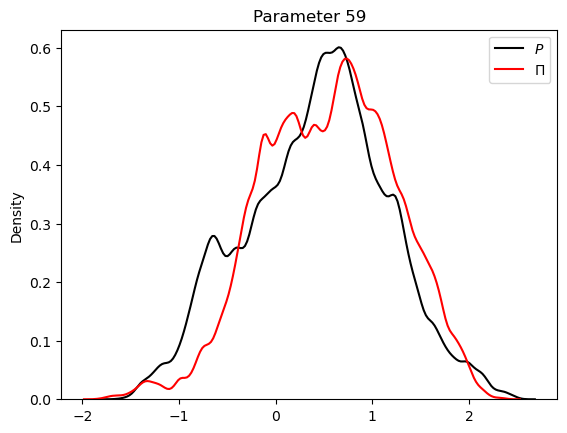

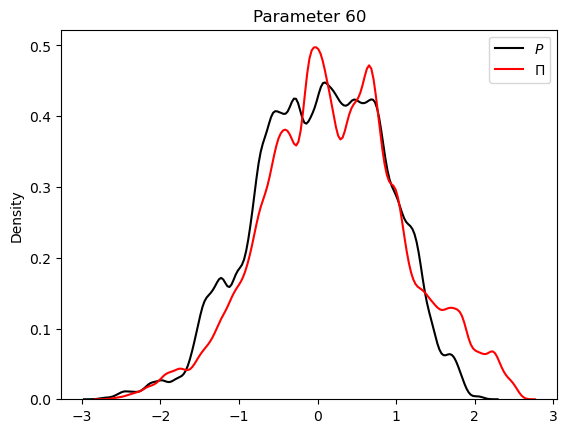

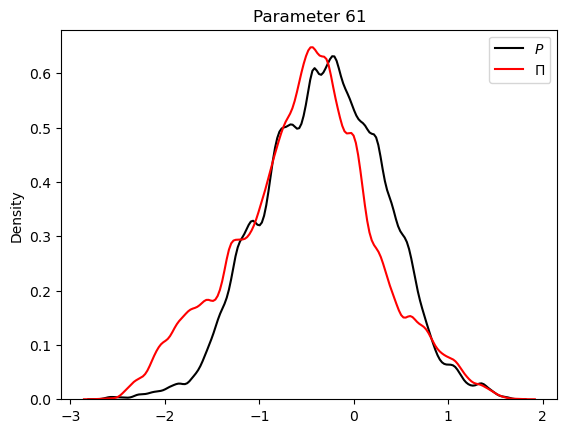

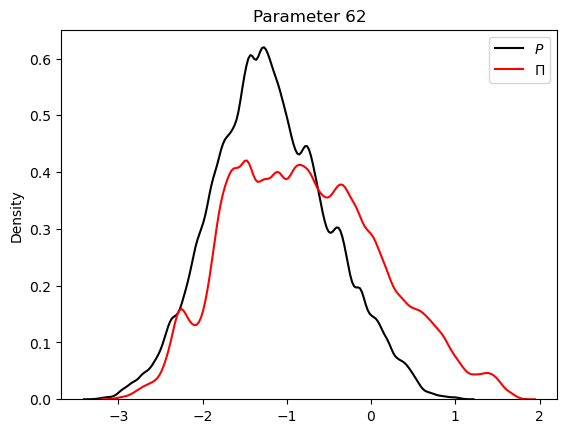

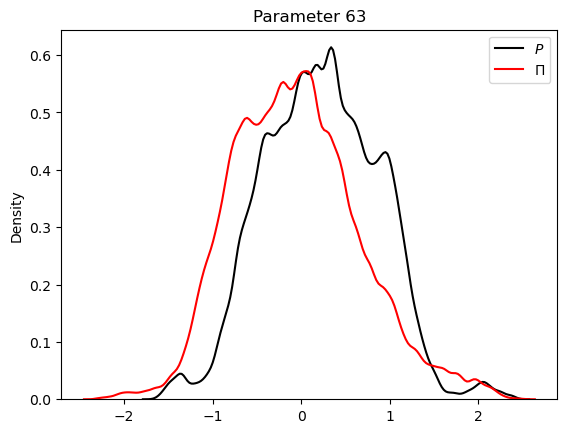

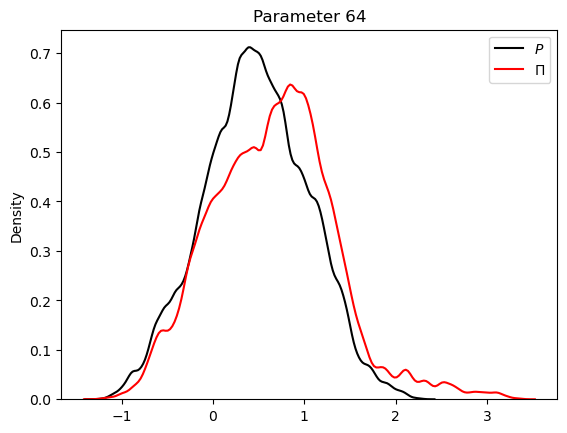

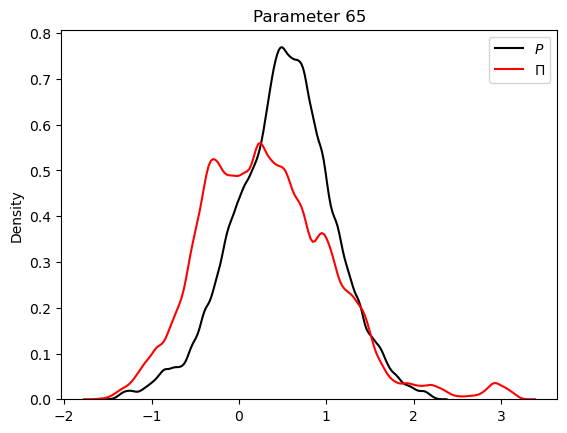

In [9]:
for i in range(dim):
    # plt.hist(x_p_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='p')
    # plt.hist(x_q_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='q')
    sns.kdeplot(x_p_unconstrain[:,i].flatten(), label='$P$', color="black")
    sns.kdeplot(x_q_unconstrain[:,i].flatten(), label='$\Pi$', color="red")

    plt.title(f"Parameter {i}")
    plt.legend()
    plt.show()

### Thinning

In [12]:
fixed_ratio = 0.1
iteration_list = [10, 20, 50, 100, 200, 500, 1000, 2000]

#IMQ
vfk0_imq = make_imq(x_p_unconstrain, grad_x_p_unconstrain, pre=nearestPD(linv))

res_ksd_p_imq = []
res_ksd_q_imq = []
res_ksd_p_thinning_imq = []
res_ksd_q_thinning_imq = []

In [13]:
# IMQ Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_imq)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_imq)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_imq)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_imq)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_imq.append(ks_p[-1])
    res_ksd_q_imq.append(ks_q[-1])

    res_ksd_p_thinning_imq.append(ks_p_thinning[-1])
    res_ksd_q_thinning_imq.append(ks_q_thinning[-1])

10 597.6857719251287
10 601.6988912942176
20 417.38573075743744
20 424.88391248276207
50 264.40161126862483
50 276.28190457818874
100 186.36895343666146
100 248.71278712546814
200 130.5275442004828
200 158.24326410724922
500 83.18285795644326
500 110.42921939337033
1000 58.88566185346859
1000 71.97928972259325
2000 41.77407153133939
2000 50.01888692168572


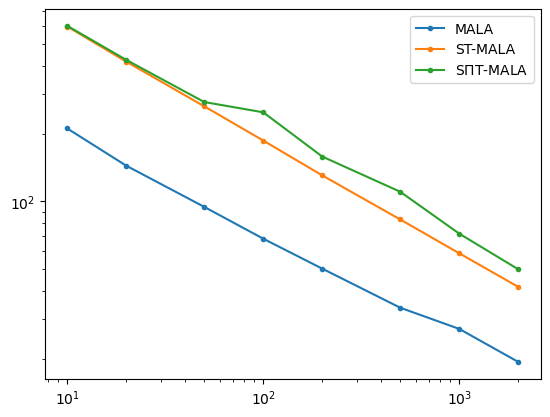

In [26]:
plt.loglog(iteration_list, res_ksd_p_imq, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_imq, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [14]:
#KGM
vfk0_centkgm = make_centkgm(x_p_unconstrain, grad_x_p_unconstrain, x_map=x_unconstrain_map, pre=nearestPD(linv), s=s)

res_ksd_p_centkgm = []
res_ksd_q_centkgm = []
res_ksd_p_thinning_centkgm = []
res_ksd_q_thinning_centkgm = []

In [15]:
# KGM Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    # print(f"No.{i} Index Calculation Begin")

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_centkgm)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_centkgm)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_centkgm)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_centkgm)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_centkgm.append(ks_p[-1])
    res_ksd_q_centkgm.append(ks_q[-1])

    res_ksd_p_thinning_centkgm.append(ks_p_thinning[-1])
    res_ksd_q_thinning_centkgm.append(ks_q_thinning[-1])

10 2469072.3812304726
10 1125136.5455248188
20 1385671.3822861505
20 1130704.0656138835
50 939422.0026110674
50 664892.3328936084
100 645090.3417767345
100 479945.32050964533
200 397486.5995932882
200 614258.1355351644
500 199877.11368895642
500 362730.89444674953
1000 117600.45059138596
1000 404865.2559356576
2000 81765.89797045915
2000 211255.32078901143


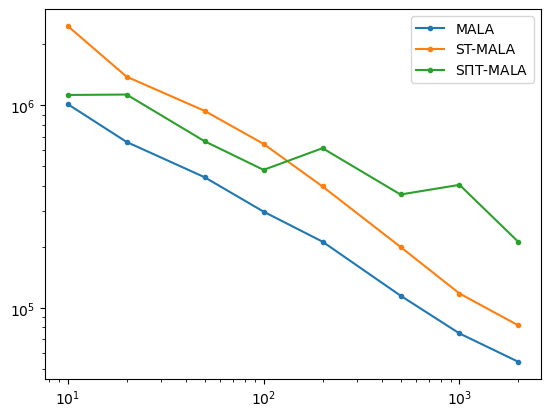

In [16]:
plt.loglog(iteration_list, res_ksd_p_centkgm, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_centkgm, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

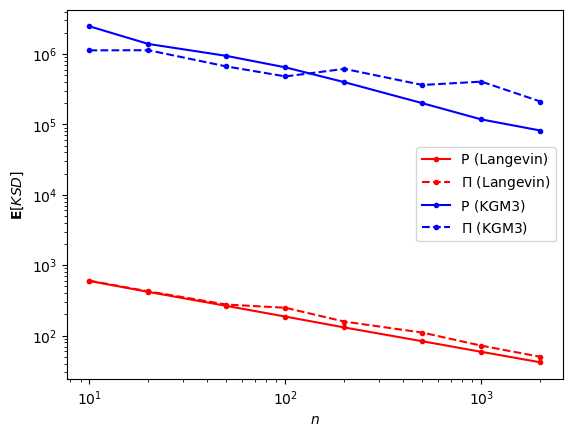

In [17]:
plt.loglog(iteration_list, res_ksd_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$KSD$]')
plt.legend()

### WasserStein

In [18]:
gs = np.zeros_like(gs_chains.T)
# gs = np.zeros_like(gs_matrix)

for i in range(gs_chains.T.shape[0]):
    gs[i] = model.param_unconstrain(gs_chains.T[i].astype(np.float64))
# for i in range(gs_matrix.shape[0]):
#     gs[i] = model.param_unconstrain(gs_matrix[i].astype(np.float64))
emd = wasserstein.EMD(n_iter_max=1_000_000)
gs_weights = np.repeat(1/gs.shape[0], gs.shape[0])

In [19]:
#IMQ
res_wass_p_imq = []
res_wass_q_imq = []
res_wass_p_thinning_imq = []
res_wass_q_thinning_imq = []

In [20]:
# IMQ Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_imq.append(wass_p)
    res_wass_q_imq.append(wass_q)

    res_wass_p_thinning_imq.append(wass_p_thinning)
    res_wass_q_thinning_imq.append(wass_q_thinning)

10 14.945014989264228
10 14.974688300057197
20 14.93935787006511
20 14.968413297608402
50 14.902374793625606
50 14.958978269753658
100 14.911864667728056
100 14.953689253025592
200 14.907720604401392
200 14.903134464976267
500 14.870716694496645
500 14.893650777503334
1000 14.761025276209292
1000 14.79507948277149
2000 14.785574395949483
2000 14.809863603902391


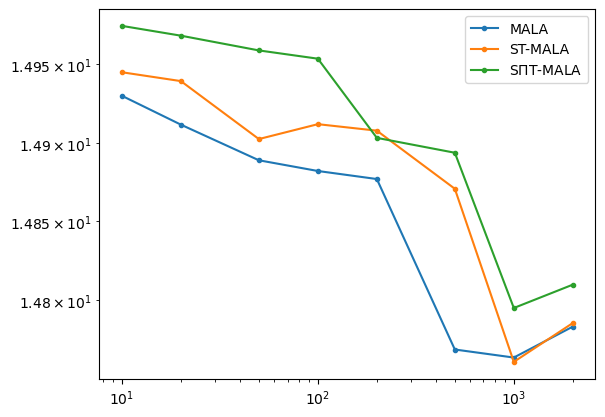

In [21]:
plt.loglog(iteration_list, res_wass_p_imq, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [22]:
#KGM
res_wass_p_centkgm = []
res_wass_q_centkgm = []
res_wass_p_thinning_centkgm = []
res_wass_q_thinning_centkgm = []

In [23]:
# KGM Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_centkgm.append(wass_p)
    res_wass_q_centkgm.append(wass_q)

    res_wass_p_thinning_centkgm.append(wass_p_thinning)
    res_wass_q_thinning_centkgm.append(wass_q_thinning)

10 14.947261539308963
10 14.97249869642106
20 14.941009777983842
20 14.974856651502673
50 14.916631633211145
50 14.966277900257696
100 14.91311589978812
100 14.954741560117432
200 14.93371028561722
200 14.938366531190324
500 14.82186010268131
500 14.903791181879912
1000 14.902726882902702
1000 14.892693206333423
2000 14.875938678810812
2000 14.955743669578911


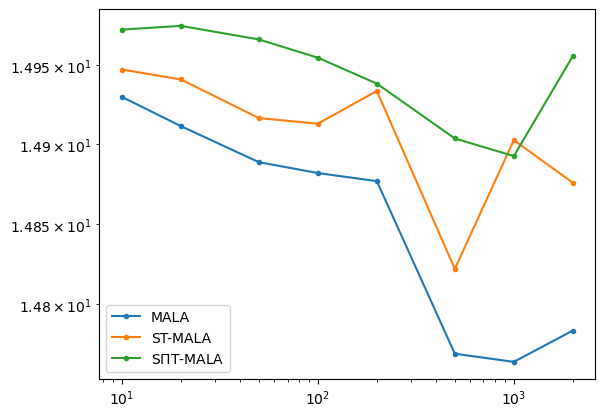

In [24]:
plt.loglog(iteration_list, res_wass_p_centkgm, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

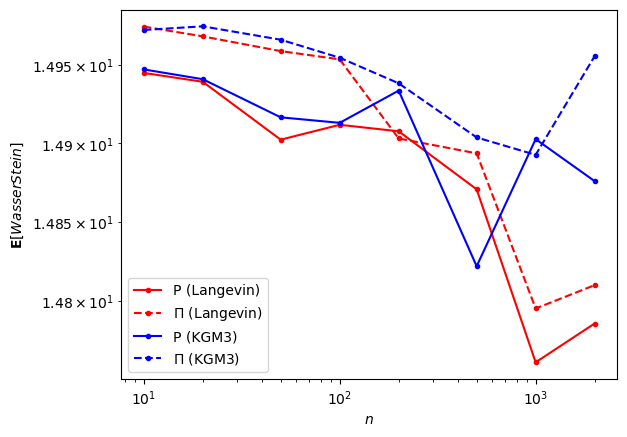

In [25]:
plt.loglog(iteration_list, res_wass_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_wass_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_wass_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$WasserStein$]')
plt.legend()